# Обучение

Создадим кастомный датасет для передачи данных в модель

У этого класса будет два режима работы:

    1. обучение, передаются ответы
    2. тестирование

Переход между режимами задаётся отсутствием ответов

In [26]:
from torch.utils.data import Dataset
import torch
from pandas import read_csv
from PIL import Image
import os
import torch
import numpy as np


if not os.path.exists('./weights'):
    os.mkdir('./weights')


class ActivitiesDataset(Dataset):
    """Human activities dataset."""

    def __init__(self, root_dir, csv_file=None, class_to_idx_csv=None, transforms=None):
        super().__init__()
        """
        Arguments:
            root_dir (string): Путь до папки с всеми изображениями
            csv_file (string, optional): Путь до csv файла с разметкой данных
            class_to_idx_csv (string, optional): Путь до файла для сопоставления классов текстовому представлению
            transform (callable, optional): Функция для произведения подготовки/аугментаций изображений
        """
        self.root_dir = root_dir
        self.csv_file = csv_file
            
        if not self.csv_file:
            self.test_data = True
            self.labels = os.listdir(self.root_dir)
        else:
            self.test_data = False
            self.activities_frame = read_csv(csv_file)
        
            if class_to_idx_csv:
                self.idx_to_class = {i[0]: i[1] for i in read_csv(class_to_idx_csv).values}
            else:
                self.idx_to_class = {int(i): '' for i in sorted(set(self.activities_frame.iloc[:,1].values))}

            answers = self.activities_frame.iloc[:,1].values
            contain = np.array([np.sum(answers == idx) for idx in self.idx_to_class]) / len(answers)
            contain[contain == 0] = 1
            self.weights = torch.tensor(1 / contain).to(dtype=torch.float)
            
        self.class_to_idx_csv = class_to_idx_csv
        self.transforms = transforms
        self.root_dir = root_dir
        self.transforms = transforms

    def __len__(self):
        if self.test_data:
            return len(self.labels)
            
        return len(self.activities_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if not self.test_data:
            img_path = os.path.join(self.root_dir, str(self.activities_frame.iloc[idx, 0]) + '.jpg')
            image = Image.open(img_path)
            label = self.activities_frame.iloc[idx, 1]
    
            if self.transforms:
                image = self.transforms(image)
        else:
            img_path = os.path.join(self.root_dir, self.labels[idx])
            image = Image.open(img_path)
    
            if self.transforms:
                image = self.transforms(image)
            label = os.path.splitext(os.path.split(img_path)[-1])[0]

        sample = image, label
        return sample

    def copy(self):
        return ActivitiesDataset(self.root_dir, self.csv_file, self.class_to_idx_csv, self.transforms)

Зададим функции для получения одинакового разрешения картинок (320х240) и аугментаций для улучшения обобщающих функций сети.

In [2]:
from torchvision.transforms import v2


transforms_train = v2.Compose([
    v2.PILToTensor(),
    # v2.Resize(size=(240, 320)),
    v2.ToDtype(torch.float32, scale=True),
])

transforms = v2.Compose([
    v2.PILToTensor(),
    v2.Resize(size=(240, 320)),
    v2.ToDtype(torch.float32, scale=True),
])

transforms_1 = v2.Compose([
    v2.PILToTensor(),
    v2.RandomResizedCrop((240, 320)),
    v2.RandomHorizontalFlip(0.2),
    v2.ToDtype(torch.float32, scale=True),
])

Для ускорения обучения уменьшим изображения, что ускорит процесс их передачи в модель на каждой итерации

In [3]:
from PIL import Image
import os
import tqdm


images_root = './human_poses_data'

# 144p = 256x144
# 240p = 320x240

root = os.path.join(images_root, 'img_train')
dest = os.path.join(images_root, 'img_train_sized_240p')
if not os.path.exists(dest):
    os.mkdir(dest)

    for file_name in tqdm.tqdm(os.listdir(root)):
        img = Image.open(os.path.join(root, file_name))
        img.resize((320, 240)).save(os.path.join(dest, file_name))

Создадим датасет для обучающих данных

при установке флага ```train_on_all``` модель будет учиться не разделяя данные

In [4]:
train = ActivitiesDataset(
    root_dir=os.path.join(images_root, 'img_train_sized_240p'),
    csv_file=os.path.join(images_root, 'train_answers.csv'), 
    class_to_idx_csv=os.path.join(images_root, 'activity_categories.csv'),
    transforms=transforms_train,
)

train_on_all = False
weights_path = './res-weights' if train_on_all else './weights'
if not os.path.exists(weights_path):
    os.mkdir(weights_path)

train.weights

tensor([ 4.9232, 91.6074, 23.3340,  7.3613, 16.4455, 12.5937, 15.4587,  1.0000,
        23.2026, 10.1120, 31.7103, 23.4223, 26.3689, 27.9796, 54.2412,  1.0000,
        16.4236,  1.0000, 30.1634,  1.0000])

Визуализруем полученный датасет

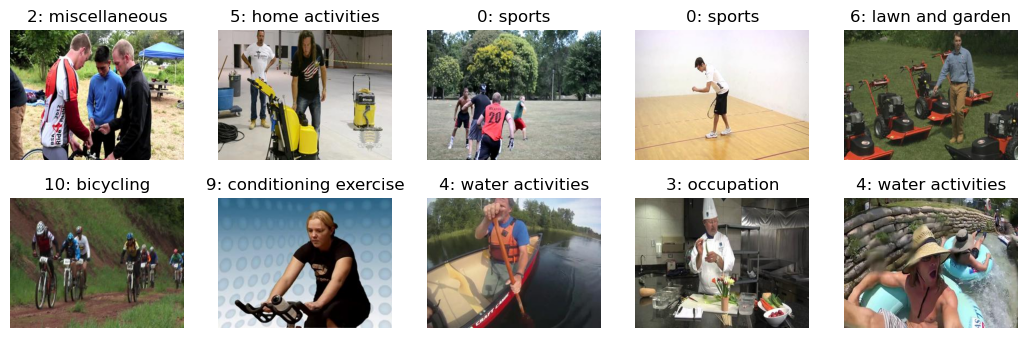

In [5]:
from matplotlib import pyplot as plt


fig = plt.figure(figsize=(13, 4))

for i, sample in enumerate(train):
    ax = plt.subplot(2, 5, i + 1)
    ax.set_title(f'{sample[1]}: {train.idx_to_class[sample[1]]}')
    ax.axis('off')
    ax.imshow(sample[0].permute(1, 2, 0))

    if i == 9:
        plt.show()
        break

Выведем соответствие индексов классам

In [6]:
train.idx_to_class

{0: 'sports',
 1: 'inactivity quiet/light',
 2: 'miscellaneous',
 3: 'occupation',
 4: 'water activities',
 5: 'home activities',
 6: 'lawn and garden',
 7: 'religious activities',
 8: 'winter activities',
 9: 'conditioning exercise',
 10: 'bicycling',
 11: 'fishing and hunting',
 12: 'dancing',
 13: 'walking',
 14: 'running',
 15: 'self care',
 16: 'home repair',
 17: 'volunteer activities',
 18: 'music playing',
 19: 'transportation'}

Зададим модель и её архитектуру

In [7]:
from torch import nn
from torchsummary import summary


model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(64, 128, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(128, 256, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Dropout(0.05),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(in_features=2048, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(in_features=512, out_features=64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=20),
        )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = model.to(device)
summary(model, (3, 240, 320))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 119, 159]             896
         MaxPool2d-2           [-1, 32, 59, 79]               0
              ReLU-3           [-1, 32, 59, 79]               0
           Dropout-4           [-1, 32, 59, 79]               0
            Conv2d-5           [-1, 64, 29, 39]          18,496
         MaxPool2d-6           [-1, 64, 14, 19]               0
              ReLU-7           [-1, 64, 14, 19]               0
           Dropout-8           [-1, 64, 14, 19]               0
            Conv2d-9            [-1, 128, 6, 9]          73,856
             ReLU-10            [-1, 128, 6, 9]               0
          Dropout-11            [-1, 128, 6, 9]               0
           Conv2d-12            [-1, 256, 2, 4]         295,168
             ReLU-13            [-1, 256, 2, 4]               0
          Dropout-14            [-1

Разделим данные для обучения и зададим гиперпараметры, функцию потерь и оптимизатор

при установке (выше) флага ```train_on_all``` модель будет учиться не разделяя данные

Доступны режимы ```train_way``` (только при ```train_on_all = False```):

    1. 'test only'
    2. 'validation only'

При выборе соответсвующего режима меняется способ разделения данных

In [8]:
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm.notebook import tqdm
import pickle
from copy import deepcopy


train_n = int(len(train) * 0.85)
sep_n = len(train) - train_n

loss_function = nn.CrossEntropyLoss(weight=train.weights)
optimizer = optim.Adamax(model.parameters(), lr=1e-3)

BATCH_SIZE = 101
NUM_EPOCHS = 300

loader_pathes = {path: os.path.join(weights_path, path + '.loader') for path in ('train', 'sep')}
history_pathes = {path: os.path.join(weights_path, path + '_hist.txt') for path in ('train', 'sep')}
train_way = 'validation only'  # 'test only' | 'validation only'

if not os.path.exists(loader_pathes['train']):
    if train_on_all:
        train_set = train
        
        tr1 = train.copy()
        tr1.transforms = transforms_1
        tr2 = train.copy()
        tr2.transforms = transforms_1
    else:
        train_set, separated_set = random_split(train, [train_n, sep_n])

        if train_way == 'test only':
            tr1 = deepcopy(train_set)
            tr1.dataset.transforms = transforms_1
            tr2 = deepcopy(train_set)
            tr2.dataset.transforms = transforms_1
        elif train_way == 'validation only':
            tr1 = train.copy()
            tr1.transforms = transforms_1
            tr2 = train.copy()
            tr2.transforms = transforms_1

    train_loader = DataLoader(train_set + tr1 + tr2, batch_size=BATCH_SIZE)
    with open(loader_pathes['train'], 'wb') as out:
        pickle.dump(train_loader, out)
        
    if not train_on_all:
        sep_loader = DataLoader(separated_set, batch_size=BATCH_SIZE)
        with open(loader_pathes['sep'], 'wb') as out:
            pickle.dump(sep_loader, out)
else:
    with open(loader_pathes['train'], 'rb') as out:
        train_loader = pickle.load(out)

    if not train_on_all:
        with open(loader_pathes['sep'], 'rb') as out:
            sep_loader = pickle.load(out)


print(len(train_loader))

349


Зададим функцию для подсчёта TPFN на каждом шаге, для накопительной суммы и усреднения на эпоху

In [9]:
def calc_tpfn(pred, y):
    pred_ = pred.cpu().detach().numpy()

    classes = np.ones(20)

    pred_c = np.zeros_like(pred_)
    pred_c[np.arange(pred_c.shape[0]), pred.cpu().argmax(dim=1)] = 1
    y_c = np.zeros_like(pred_)
    y_c[np.arange(pred_c.shape[0]), y.cpu()] = 1

    TP = np.sum((pred_c == classes) * (y_c == classes), axis=0)
    FP = np.sum((pred_c == classes) * (y_c != classes), axis=0)
    TN = np.sum((pred_c != classes) * (y_c != classes), axis=0)
    FN = np.sum((pred_c != classes) * (y_c == classes), axis=0)

    return TP, FP, TN, FN

Зададим функции для сохранения полученных в модели и загрузки уже сохранённых весов

In [23]:
train_hist = []
sep_hist = []


def save_weights(epoch):
    global train_hist, sep_hist
    
    torch.save(model.state_dict(), os.path.join(weights_path, str(epoch).rjust(4, "0") + '.dat'))
    with open(history_pathes['train'], 'w') as out:
        out.write('\n'.join(['\t'.join(map(str, i)) for i in train_hist]))
    if not train_on_all:
        with open(history_pathes['sep'], 'w') as out:
            out.write('\n'.join(['\t'.join(map(str, i))for i in sep_hist]))


def load_weights(epoch=None):
    global train_hist, sep_hist, weights_path

    weights_files = [i for i in os.listdir(weights_path) if os.path.splitext(i)[-1] == '.dat']
    if not len(weights_files):
        return 0

    if not epoch:
        weights_file = max(weights_files)
    else:
        weights_file = str(epoch).rjust(4, "0") + '.dat'
    print(weights_file)

    model.load_state_dict(torch.load(os.path.join(weights_path, weights_file)))
    model.eval()
    if os.path.exists(history_pathes['train']):
        with open(history_pathes['train'], 'r') as out:
            train_hist = [tuple(map(float, i.split('\t'))) for i in out.read().split('\n')]
    if not train_on_all:
        if os.path.exists(history_pathes['sep']):
            with open(history_pathes['sep'], 'r') as out:
                sep_hist = [tuple(map(float, i.split('\t'))) for i in out.read().split('\n')]

    return int(os.path.splitext(weights_file)[0]) + 1

Зададим фукцию для обучения сети

In [11]:
def run(model, dataloader, loss_function, optimizer=None):
    # set the model to evaluation or training mode
    if optimizer == None:
        model.eval()
    else:
        model.train()

    total_loss = 0
    TP, FP, TN, FN = [np.zeros(20) for i in range(4)]

    for X, y in tqdm(dataloader):
        X = X.to(device)
        y = y.to(device)

        # compute prediction
        pred = model(X)

        # compute loss
        _TP, _FP, _TN, _FN = calc_tpfn(pred, y)
        TP += _TP
        FP += _FP
        TN += _TN
        FN += _FN
        loss = loss_function(pred, y)
        # save loss
        total_loss += loss.item()
        if optimizer != None:
            # compute gradients
            loss.backward()
            # do optimizer step
            optimizer.step()
            # clear gradients
            optimizer.zero_grad()

    # print(TP, FP, TN, FN, sep='\n')

    accuracy = (TP + TN) / (TP + FP + TN + FN)
    precission = (TP + 1e-6) / (TP + FP + 1e-6)
    recall = (TP + 1e-6) / (TP + FN + 1e-6)
    f1 = 2 * precission * recall / (precission + recall) # b = 1

    return total_loss / len(dataloader), accuracy, f1

Запустим обучение

In [ ]:
start_from = load_weights()

for i in range(start_from):
    print(i)
    print(*train_hist[i], sep='\t')
    print(*validation_hist[i], sep='\t')

for i in range(start_from, NUM_EPOCHS):
    print(i)
    loss, accuracy, f1 = run(model, train_loader, loss_function, optimizer)
    train_hist.append((loss, sum(accuracy) / len(accuracy), sum(f1) / len(f1)))
    print(loss, sum(accuracy) / len(accuracy), sum(f1) / len(f1), sep='\t')
    
    if not train_on_all:
        loss, accuracy, f1 = run(model, sep_loader, loss_function)
        print(loss, sum(accuracy) / len(accuracy), sum(f1) / len(f1), sep='\t')
        sep_hist.append((loss, sum(accuracy) / len(accuracy), sum(f1) / len(f1)))

    save_weights(i)

# Построение графиков

Загружаем данные об результатах оценки эпох обучения и строим график

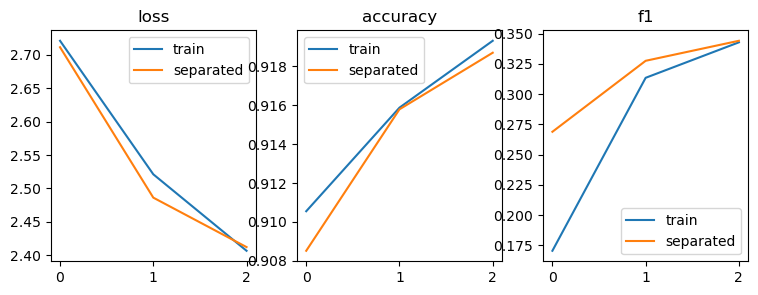

In [18]:
import numpy as np
from matplotlib import pyplot as plt


PATH = './weights'

with open(PATH + '/train_hist.txt', 'r') as out:
    train_hist = np.array([tuple(map(float, i.split('\t'))) for i in out.read().split('\n')])
with open(PATH + '/sep_hist.txt', 'r') as out:
    validation_hist = np.array([tuple(map(float, i.split('\t'))) for i in out.read().split('\n')])

range_ = np.arange(len(train_hist))

fig = plt.figure(figsize=(9, 3))
train_way_label = train.split()[0] if train_way in globals() else 'separated'

for i, type_ in enumerate(('loss', 'accuracy', 'f1')):
    ax = fig.add_subplot(1, 3, i + 1)
    ax.plot(range_, train_hist[:, i], label='train')
    ax.plot(range_, validation_hist[:, i], label=train_way_label)
    ax.legend(loc='best')
    ax.set_title(type_)

Аналогично для обучения на всех данных

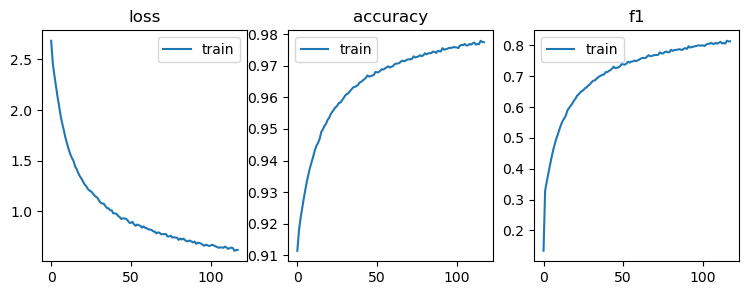

In [24]:
import numpy as np
from matplotlib import pyplot as plt


PATH = './res-weights'

with open(PATH + '/train_hist.txt', 'r') as out:
    train_hist = np.array([tuple(map(float, i.split('\t'))) for i in out.read().split('\n')])

range_ = np.arange(len(train_hist))

fig = plt.figure(figsize=(9, 3))

for i, type_ in enumerate(('loss', 'accuracy', 'f1')):
    ax = fig.add_subplot(1, 3, i + 1)
    ax.plot(range_, train_hist[:, i], label='train')
    ax.legend(loc='best')
    ax.set_title(type_)

# Сохраняем ответы на тестовые данные

Загружаем веса и сохраняем список ответов модели

In [38]:
weights_path = './res-weights'

load_weights(107)

test = ActivitiesDataset(
    root_dir=os.path.join(images_root, 'img_test'),
    class_to_idx_csv=os.path.join(images_root, 'activity_categories.csv'),
    transforms=transforms,
)

BATCH_SIZE = 101
test_loader = DataLoader(test, batch_size=BATCH_SIZE)

data = []

for X, idx in tqdm(test_loader):
    pred = model(X.to(device)).cpu().argmax(dim=1)
    data += list(zip(idx, pred))

assert len(data) == 5301

0107.dat


  0%|          | 0/53 [00:00<?, ?it/s]

Записываем полученные значения в файл

In [39]:
import datetime

with open(f'res-{datetime.datetime.now().isoformat()}.csv'.replace(':', ''), 'w') as out:
    out.write('id,target_feature\n')
    out.write('\n'.join([','.join((image, str(answer.item()))) for image, answer in data]))    